<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/causal_impact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal Impact as implemented on top of TFP SSM library

https://github.com/WillianFuks/tfcausalimpact/blob/master/notebooks/getting_started.ipynb


# Setup

In [1]:
!pip install -qq tfcausalimpact

  Created wheel for tfcausalimpact: filename=tfcausalimpact-0.0.9-py3-none-any.whl size=38366 sha256=7bb737a3311e9d06410e3de060d5b466e0b81334021768675c4664e528a55f16
  Stored in directory: /root/.cache/pip/wheels/b2/df/96/8a0832fdb37824c5b6998d6aa32dab501110ab47dfc8df9d8e
Successfully built tfcausalimpact


In [2]:
%matplotlib inline

import sys
import os


# sys.path.append(os.path.abspath('../'))


import numpy as np
import pandas as pd

try:
    import tensorflow as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow as tf
try:
    import tensorflow_probability as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability as tfp
import matplotlib.pyplot as plt

try:
    from causalimpact import CausalImpact
except ModuleNotFoundError:
    %pip install -qq causalimpact
    from causalimpact import CausalImpact


tfd = tfp.distributions
plt.rcParams["figure.figsize"] = [15, 10]

# Data

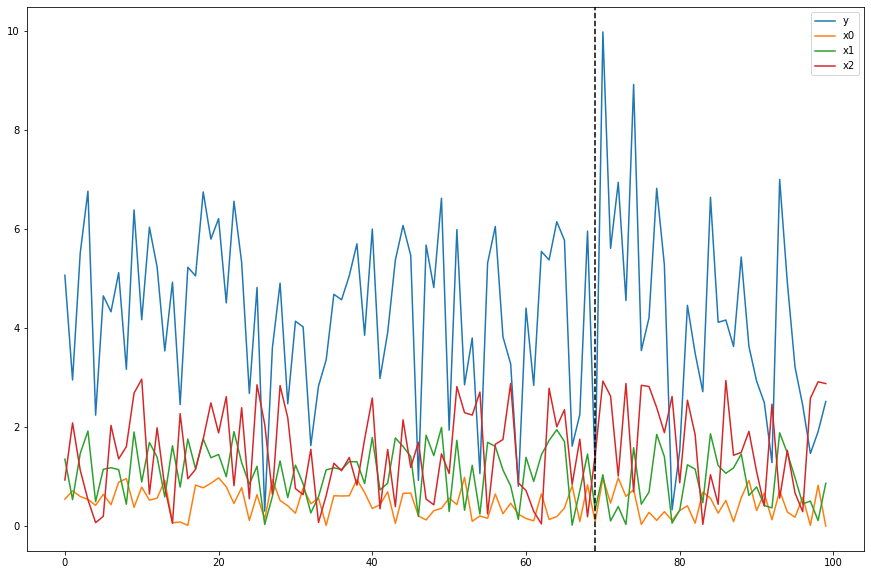

In [22]:
# This is modified from an example presented in Google's R code.
# https://google.github.io/CausalImpact/CausalImpact.html#creating-an-example-dataset
# The true generative process is y = 1.2 * x0 + 0.8 * x1 + 0 * x2 + random_walk
# where x2 is an irrelevant input variable.
# We simulate the impact of an intervention at I=70 by adding an offset of 10 (decreasing to 0) to the outcome y.

T = 100
I = 70

observed_stddev, observed_initial = (
    tf.convert_to_tensor(value=0.1, dtype=tf.float32),
    tf.convert_to_tensor(value=0.0, dtype=tf.float32),
)
level_scale_prior = tfd.LogNormal(loc=tf.math.log(0.0001 * observed_stddev), scale=1, name="level_scale_prior")
# level_scale_prior = tfd.LogNormal(loc=tf.math.log(0.05 * observed_stddev), scale=1, name='level_scale_prior')

initial_state_prior = tfd.MultivariateNormalDiag(
    loc=observed_initial[..., tf.newaxis],
    scale_diag=(tf.abs(observed_initial) + observed_stddev)[..., tf.newaxis],
    name="initial_level_prior",
)
ll_ssm = tfp.sts.LocalLevelStateSpaceModel(
    T, initial_state_prior=initial_state_prior, level_scale=level_scale_prior.sample()
)
ll_ssm_sample = np.squeeze(ll_ssm.sample().numpy())


np.random.seed(0)
x0 = 1 * np.random.rand(T)
x1 = 2 * np.random.rand(T)
x2 = 3 * np.random.rand(T)

y = 2 * x0 + 3 * x1 + ll_ssm_sample

# intervention
offset = 5
# y[I:] += offset
duration = 10
y[I : (I + duration)] += np.linspace(offset, 0, num=duration)  # decreasing effect

data = pd.DataFrame({"x0": x0, "x1": x1, "x2": x2, "y": y}, columns=["y", "x0", "x1", "x2"])

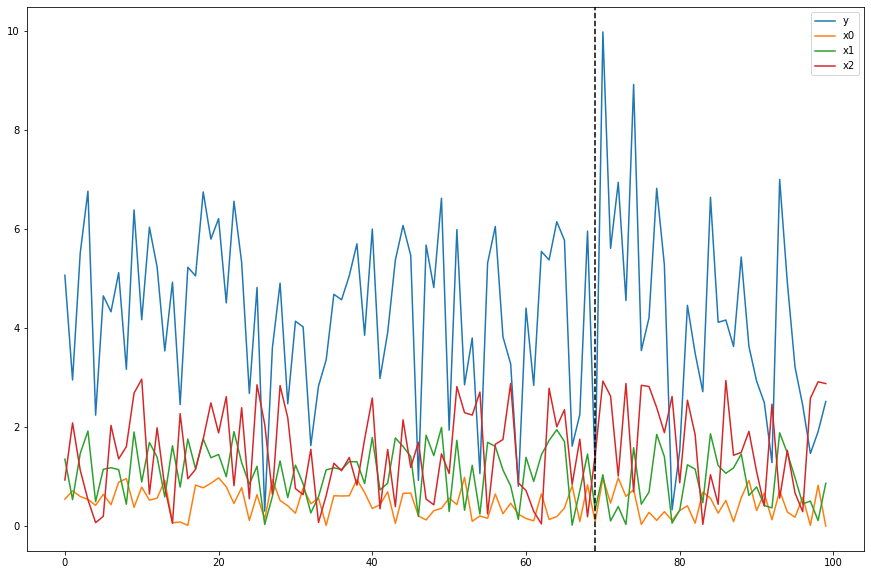

In [36]:
data.plot()
plt.axvline(I - 1, linestyle="--", color="k")
plt.legend()
plt.savefig("causal-impact-data.pdf")

# Fit default model

In [23]:
pre_period = [0, I - 1]
post_period = [I, T - 1]
ci = CausalImpact(data, pre_period, post_period)

In [33]:
print(ci.model_samples.keys())
# We sample 100 times from the variational posterior of each parameter
# https://github.com/WillianFuks/tfcausalimpact/blob/master/causalimpact/model.py#L378

for name, values in ci.model_samples.items():
    print(f"{name}: {values.numpy().mean(axis=0)}")

odict_keys(['observation_noise_scale', 'LocalLevel/_level_scale', 'SparseLinearRegression/_global_scale_variance', 'SparseLinearRegression/_global_scale_noncentered', 'SparseLinearRegression/_local_scale_variances', 'SparseLinearRegression/_local_scales_noncentered', 'SparseLinearRegression/_weights_noncentered'])
observation_noise_scale: 0.34998977184295654
LocalLevel/_level_scale: 0.010700251907110214
SparseLinearRegression/_global_scale_variance: 1.5136687755584717
SparseLinearRegression/_global_scale_noncentered: 1.5066444873809814
SparseLinearRegression/_local_scale_variances: [1.0874447 2.730983  0.8268008]
SparseLinearRegression/_local_scales_noncentered: [1.2025315  1.7309521  0.44093436]
SparseLinearRegression/_weights_noncentered: [ 1.4927632   1.945029   -0.10319362]


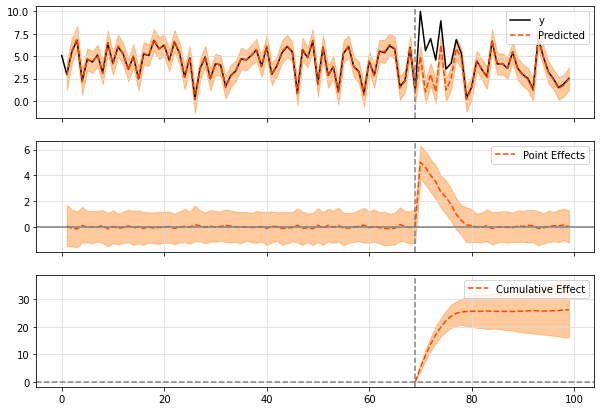

In [39]:
ci.plot(show=False)
fig = plt.gcf()
fig.savefig("causal-impact-inferences.pdf")

In [35]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    4.21               126.28
Prediction (s.d.)         3.34 (0.18)        100.14 (5.26)
95% CI                    [3.0, 3.69]        [90.03, 110.63]

Absolute effect (s.d.)    0.87 (0.18)        26.14 (5.26)
95% CI                    [0.52, 1.21]       [15.65, 36.25]

Relative effect (s.d.)    26.1% (5.25%)      26.1% (5.25%)
95% CI                    [15.63%, 36.2%]    [15.63%, 36.2%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
